In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from dipy.io.image import save_nifti
import numpy as np
from dipy.data import read_stanford_hardi, read_stanford_pve_maps
import torch
import torch.nn as nn
from dipy.segment.mask import median_otsu

from scipy.ndimage.morphology import binary_erosion

import difreewater

### Load data

In [3]:
# Diffusion weighted data
img, gtab = read_stanford_hardi()
dwi = img.get_data()

# Segmentation maps
(csf, gm, wm) = [map.get_data()==1.0 for map in read_stanford_pve_maps()]

# The provided segmentation maps are quite noisy in the lower parts of the brain, so we clip the segmentation maps 
# at z=25, and use only the ventricles for CSF data.
v_mask = np.zeros(csf.shape)
(x,y,z) = np.divide(csf.shape,2).astype(np.int)
v_mask[x-15:x+15,y-20:y+20,z-5:z+5] = 1
csf = np.logical_and(csf, v_mask)

wm[:,:,:25] = 0
gm[:,:,:25] = 0

# Erode the maps so obtained exemplary voxels are not contaminated by other tissue
csf, gm, wm = [binary_erosion(map) for map in (csf, gm, wm)]

maskdata, mask = median_otsu(dwi, vol_idx=range(10, 50), median_radius=3,
                             numpass=1, autocrop=True, dilate=2)

Dataset is already in place. If you want to fetch it again please first remove the folder /Users/leon/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /Users/leon/.dipy/stanford_hardi 


### Create the synthetic training data set

In [4]:
synDataLoader = difreewater.SynDiffData(gtab, dwi, csf_mask=csf, gm_mask=gm, wm_mask=wm)
syn_diff_data, water_fraction = synDataLoader.create_waterfraction_data(sample_size=250000) # this may take a while

### Neural network training

In [4]:
net = difreewater.learning.train(syn_diff_data, water_fraction, num_epochs=100)

Epoch 0: MSE=0.07654629647731781, ME=0.2235696166753769
Epoch 1: MSE=0.03842276707291603, ME=0.15202267467975616
Epoch 2: MSE=0.02057836577296257, ME=0.11543473601341248
Epoch 3: MSE=0.01745826005935669, ME=0.11254231631755829
Epoch 4: MSE=0.007663290947675705, ME=0.07598821818828583
Epoch 5: MSE=0.004137392621487379, ME=0.05401128530502319
Epoch 6: MSE=0.002239665947854519, ME=0.03418423607945442
Epoch 7: MSE=0.002152310451492667, ME=0.03136271610856056
Epoch 8: MSE=0.0017866464331746101, ME=0.03064129501581192
Epoch 9: MSE=0.001514673000201583, ME=0.02671777829527855
Epoch 10: MSE=0.001444527180865407, ME=0.02608044072985649
Epoch 11: MSE=0.0013418637681752443, ME=0.025670383125543594
Epoch 12: MSE=0.0012906250776723027, ME=0.02490542083978653
Epoch 13: MSE=0.001248840126208961, ME=0.024716755375266075
Epoch 14: MSE=0.0012951213866472244, ME=0.026542913168668747
Epoch 15: MSE=0.0011984951561316848, ME=0.02441166527569294
Epoch 16: MSE=0.0011793227167800069, ME=0.024650514125823975
Ep

### Predict and correct the water fraction in the original data

In [5]:
f_fw_predicted, dwi_water_corrected = difreewater.dehydrate(maskdata, mask, synDataLoader, net)

### Visualizations and save data

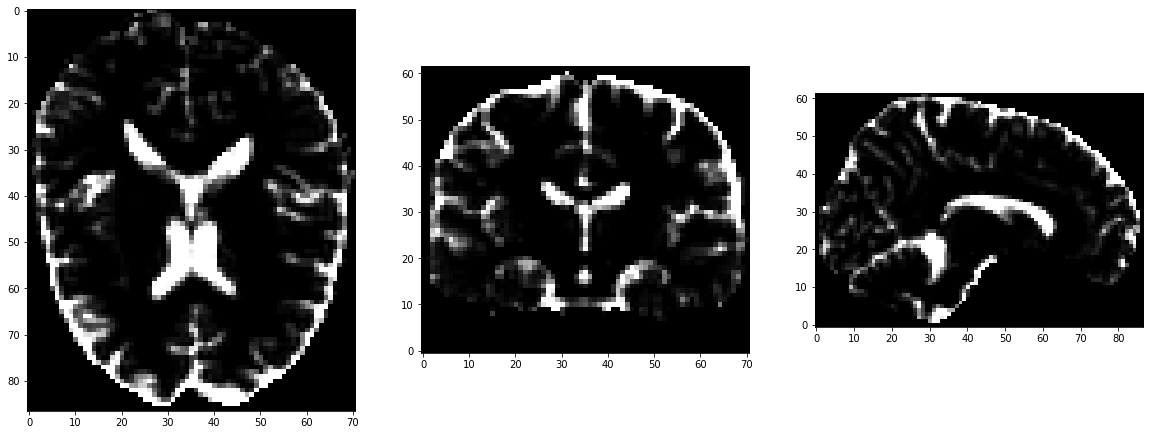

In [6]:
plt.rcParams["figure.figsize"] = (20,10)
plt.figure('water fraction')
plt.subplot(1, 3, 1)
plt.imshow(f_fw_predicted[:,:,30].T, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(f_fw_predicted[:,40,:].T, origin='lower', cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(f_fw_predicted[30,:,:].T, origin='lower', cmap='gray')

save_nifti("f_fw.nii.gz", f_fw_predicted, img.affine)
save_nifti("dwi_fwe.nii.gz", dwi_water_corrected, img.affine)